# 演示在B220上使用cv2，进行colorDetect
## 有关hdmi Out的支持，参考hdmiOverlay.ipynb

In [1]:
from pynq import Overlay
from pynq.lib.video import *

base = Overlay("./overlay/hdmi.bit")
# hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

## Getting started

First we'll use the default pixel format which is 24 bit-per-pixel BGR formatted data for ease of use with OpenCV. 

In [2]:
# monitor configuration: 640*480 @ 60Hz
Mode = VideoMode(640,480,24)
# hdmi_out = base.video.hdmi_out
hdmi_out.configure(Mode,PIXEL_BGR)
hdmi_out.start()

In [3]:
# monitor (output) frame buffer size
frame_out_w = 1280
frame_out_h = 960
# camera (input) configuration
frame_in_w = 640
frame_in_h = 480

## start opencv2 colorDetect

### first step
使用fswebcame 视频捕获, videoIn = cv2.VideoCapture(0) ok; 但ret, frame = videoIn.read()无frame 返回

In [4]:
!mkdir /ram-dir
!mount ramfs -t ramfs /ram-dir

mkdir: cannot create directory ‘/ram-dir’: File exists


In [5]:
# currentpwd = !pwd
# currentpwd[0]
# # 拷贝一个源文件至ramfs
# jpgfile = currentpwd[0] + "/image/webcam.jpg"
# jpgfile
!cp /home/xilinx/jupyter_notebooks/openCV2_colorDetect/image/webcam.jpg /ram-dir -f

In [6]:
orig_img_path = '/ram-dir/webcam.jpg'
!fswebcam --no-banner --resolution 640x480 --save {orig_img_path} -d /dev/video0 2> /dev/null        #如果webcam 存在，替换原图

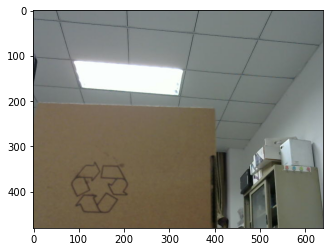

In [7]:
# jupyternotebook 显示原始图片
import matplotlib.pyplot as plt
import matplotlib.image as img
image = img.imread('/ram-dir/webcam.jpg') 
plt.imshow(image)

In [8]:
import cv2
import numpy as np
frame = cv2.imread('/ram-dir/webcam.jpg')

In [9]:
color = (255,255,255)
# using HSV colormap for the selection
red_lower = np.array([161, 165, 111], np.uint8)
red_upper = np.array([180, 255, 255], np.uint8)

green_lower = np.array([50, 65, 50], np.uint8)
green_upper = np.array([70, 255, 255], np.uint8)

blue_lower = np.array([100, 150, 50], np.uint8)
blue_upper = np.array([130, 255, 255], np.uint8)

yellow_lower = np.array([24, 0, 20], np.uint8)
yellow_upper = np.array([39, 255, 255], np.uint8)

orange_lower = np.array([16, 100, 20], np.uint8)
orange_upper = np.array([24, 255, 255], np.uint8)

light_lower = np.array([85, 50, 20], np.uint8)
light_upper = np.array([95, 255, 255], np.uint8)

color_list = {'blue':  [blue_lower, blue_upper], 
              'red' :  [red_lower, red_upper],
              'yellow':[yellow_lower,yellow_upper],
              'orange':[orange_lower, orange_upper],
              'light': [light_lower,light_upper],
             }

def det_color(frame, points):
    mask = cv2.inRange(frame, points[0], points[1])
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 4000:
            M = cv2.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            return c, cx, cy

In [10]:

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
for name, point in color_list.items():
    if det_color(hsv, point):
        c, cx, cy = det_color(hsv, point)
        cv2.drawContours(frame, [c], -1, color, 3)
        cv2.circle(frame, (cx, cy), 7, color, -1)
        cv2.putText(frame, name, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1)
        
        outframe = hdmi_out.newframe()
        outframe[:] = frame
        hdmi_out.writeframe(outframe)

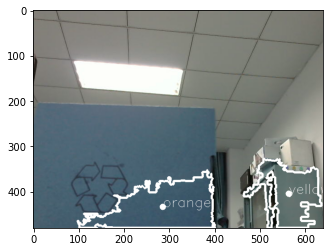

In [11]:
plt.imshow(frame)